In [1]:
# Initial imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

  # Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
#set path to Features CSV and read in CSV
msft_df = pd.read_pickle('Resources/msft_features_df.pickle')
msft_df.head()

,msft Close,msft Volume,Call Volume,Put Volume,Total Option Volume,Percent of Put,Put signals,Percent of calls,Call signals,bollinger_mid_band,...,rvol SD,rvol signal,Option rVol,Option rVol SD,Option rVol signal,daily returns,sent_by_sentence_score,sentiment neg,sentiment pos,sentiment score
2019-08-05,132.20,35492393,405627.0,373180.0,778807.0,0.479169,False,0.520831,False,138.11175,...,1.331905,1.0,1.773845,1.331905,1.0,-0.034332,-1.9771,-1,0,-1
2019-08-06,134.66,25230023,319702.0,219420.0,539122.0,0.406995,False,0.593005,False,137.99625,...,1.352238,0.0,1.226958,1.352238,0.0,0.018608,0.0000,0,0,0
2019-08-07,135.28,26194932,285495.0,223024.0,508519.0,0.438576,False,0.561424,False,137.93850,...,1.369183,0.0,1.125804,1.369183,0.0,0.004604,0.3612,0,1,1
2019-08-08,138.91,20703630,586947.0,354648.0,941595.0,0.376646,False,0.623354,True,137.99100,...,1.367801,0.0,1.952782,1.367801,0.0,0.026833,0.0000,0,0,0
2019-08-09,137.69,19270704,261899.0,255741.0,517640.0,0.494052,False,0.505948,False,137.95550,...,1.360587,0.0,1.053826,1.360587,0.0,-0.008783,0.0000,0,0,0


In [3]:
#Create new trading signals Df, Set index as datetime object and drop extraneous columns
trading_signals_df = pd.DataFrame()

In [4]:
#add daily change rates to increase the staionarity of dataset
trading_signals_df['volume delta'] = msft_df['msft Volume'].dropna().pct_change()
trading_signals_df['bb std delta'] = msft_df['bollinger_std'].dropna().pct_change()
trading_signals_df['rvol delta'] = msft_df['rvol'].dropna().pct_change()
trading_signals_df['option rvol delta'] = msft_df['Option rVol'].dropna().pct_change()
trading_signals_df['sentiment'] = msft_df['sent_by_sentence_score'].fillna(0).pct_change()

#add daily returns as target
trading_signals_df['daily returns'] = msft_df['daily returns'].dropna()

trading_signals_df= trading_signals_df.fillna(value = 0)
trading_signals_df= trading_signals_df.replace([np.inf, -np.inf], 0.0)
trading_signals_df.head()

,volume delta,bb std delta,rvol delta,option rvol delta,sentiment,daily returns
2019-08-05,0.000000,0.000000,0.000000,0.000000,0.0,-0.034332
2019-08-06,-0.289143,0.056575,-0.309059,-0.308306,-1.0,0.018608
2019-08-07,0.038244,0.024259,0.012978,-0.082443,0.0,0.004604
2019-08-08,-0.209632,0.004229,-0.214210,0.734567,-1.0,0.026833
2019-08-09,-0.069211,-0.000485,-0.068979,-0.460347,0.0,-0.008783


In [5]:
 def window_data(window):
    """
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(trading_signals_df) - window):
        features = trading_signals_df.iloc[i : (i + window), :]
        target = trading_signals_df.iloc[(i + window), -1]
        X.append(features)
        y.append(target)
    
    return np.array(X), np.array(y).reshape(-1, 1)

In [6]:
# Define the window size
window_size = 7

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(window_size)



In [7]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [8]:
scalers = {}
for i in range(X_train.shape[1]):
    scalers[i] = MinMaxScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

for i in range(X_test.shape[1]):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :])



In [9]:
scaler = MinMaxScaler()
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [10]:
# Define the Transformer model.
model = Sequential()

# Initial model setup
number_units = 7
dropout_fraction = 0.3
inputs = len(trading_signals_df.columns)

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X.shape[1], inputs))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1, activation = 'linear'))

In [11]:
# Compile the LSTM model
model.compile(optimizer="adam", loss="mean_squared_error")

In [12]:
# Show the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 7)              392       
_________________________________________________________________
dropout (Dropout)            (None, 7, 7)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 7)              420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7)                 420       
_________________________________________________________________
dropout_2 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8

In [13]:
 # Train the model
model.fit(X_train, y_train, epochs=100, shuffle=False, verbose=0)

In [14]:
 # Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [15]:
#Recover the original, nonscaled prices
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [16]:
# Create a DataFrame of Real and Predicted values, shifted by forward window
shift =7
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = trading_signals_df.index[-len(real_prices)-shift:-shift ] )


# Show the DataFrame's head
stocks

,Actual,Predicted
2019-11-12,-0.000869,0.000690
2019-11-13,0.000937,0.000910
2019-11-14,0.010658,0.000428
2019-11-15,0.005127,0.000399
2019-11-18,0.002237,-0.000357
2019-11-19,-0.006302,-0.000477
2019-11-20,-0.012089,-0.000739
2019-11-21,-0.001538,-0.001179
2019-11-22,0.003415,-0.001279
2019-11-25,0.000601,-0.001271


In [17]:
#convert stocks df into positive and negative signals
stocks['Positive Actual signal'] = np.where(stocks['Actual'] > 0, 1, 0)
stocks['Negative Actual signal'] = np.where(stocks['Actual'] < 0, -1, 0)

stocks['Positive Predicted signal'] = np.where(stocks['Predicted'] > 0, 1, 0)
stocks['Negative Predicted signal'] = np.where(stocks['Predicted'] < 0, -1, 0)

#merge to create one column per signal, shifted back to reflect forward projection window
shift = 7
stocks['Actual Signal'] = stocks['Positive Actual signal'] + stocks['Negative Actual signal']
stocks['LSTM Predicted Signal'] = stocks['Positive Predicted signal'] + stocks['Negative Predicted signal']
stocks

,Actual,Predicted,Positive Actual signal,Negative Actual signal,Positive Predicted signal,Negative Predicted signal,Actual Signal,LSTM Predicted Signal
2019-11-12,-0.000869,0.000690,0,-1,1,0,-1,1
2019-11-13,0.000937,0.000910,1,0,1,0,1,1
2019-11-14,0.010658,0.000428,1,0,1,0,1,1
2019-11-15,0.005127,0.000399,1,0,1,0,1,1
2019-11-18,0.002237,-0.000357,1,0,0,-1,1,-1
2019-11-19,-0.006302,-0.000477,0,-1,0,-1,-1,-1
2019-11-20,-0.012089,-0.000739,0,-1,0,-1,-1,-1
2019-11-21,-0.001538,-0.001179,0,-1,0,-1,-1,-1
2019-11-22,0.003415,-0.001279,1,0,0,-1,1,-1
2019-11-25,0.000601,-0.001271,1,0,0,-1,1,-1


In [18]:
stocks['LSTM Predicted Signal'].to_pickle(r'C:\Users\Kiel\Desktop\FINTECH\UCB_fintech_homework\project_2 - local\Resources\msft_LSTM_signals_df.pickle')

<AxesSubplot:>

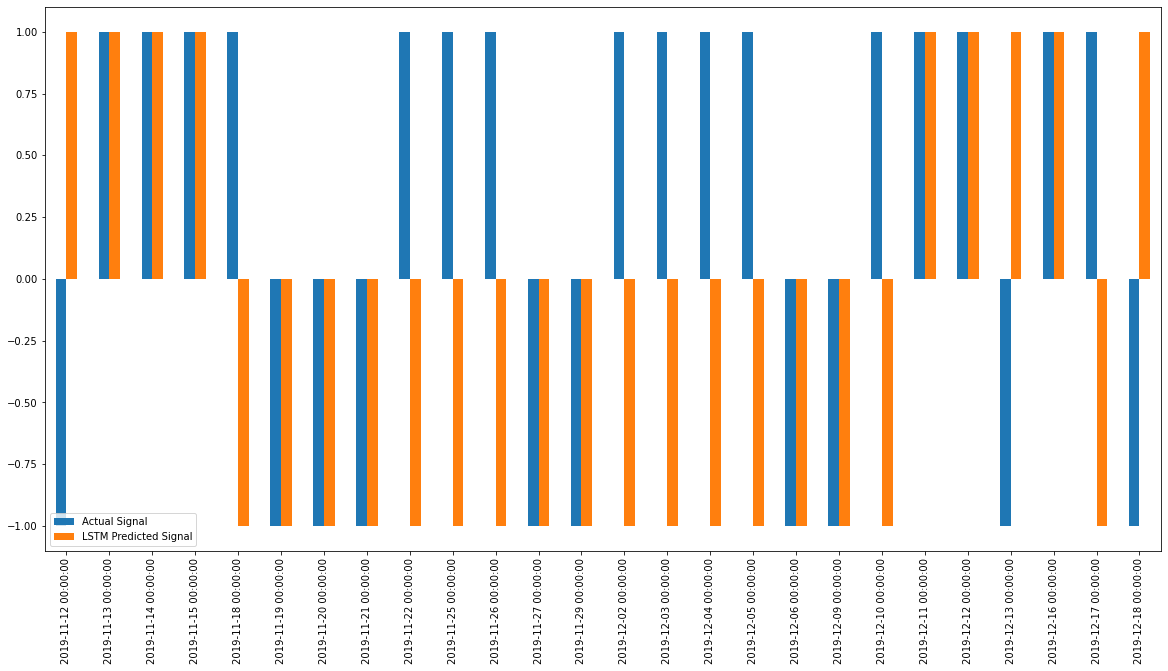

In [19]:
stocks.plot(y = ['Actual Signal', 'LSTM Predicted Signal'], figsize = (20,10), kind = 'bar')

<AxesSubplot:>

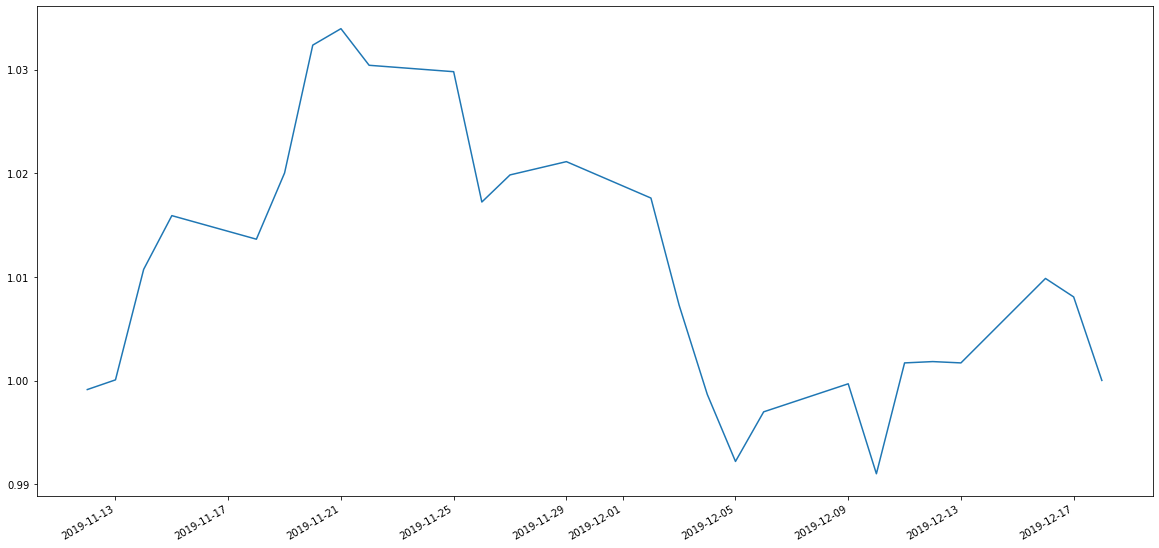

In [20]:
# Calculate cumulative return of model and plot the result
(1 + (stocks['Actual'] * stocks['LSTM Predicted Signal'])).cumprod().plot(figsize = (20,10))

<AxesSubplot:>

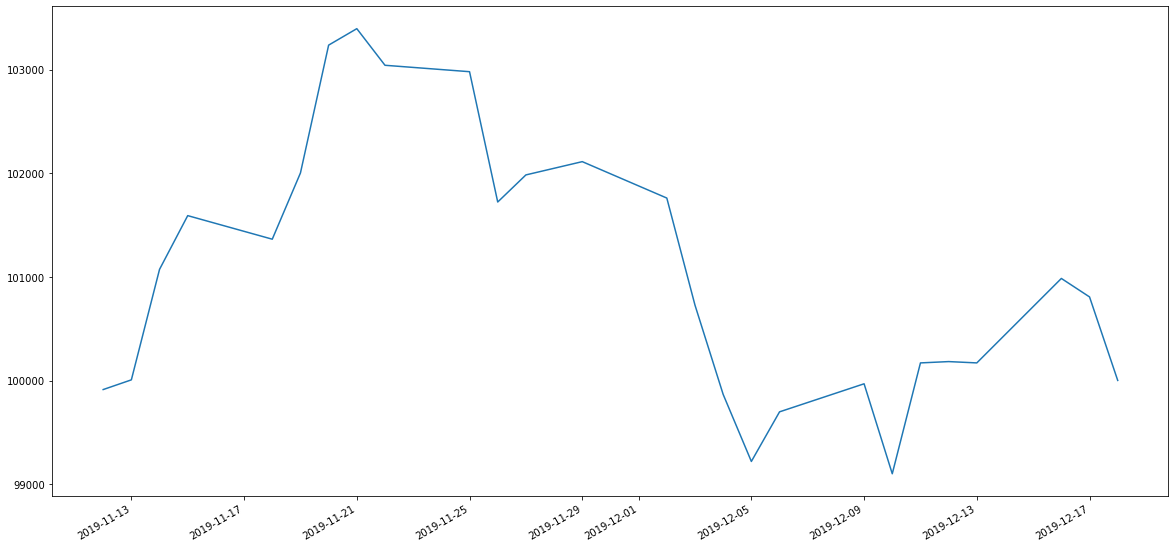

In [21]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (stocks['Actual'] * stocks['LSTM Predicted Signal'])).cumprod()
cumulative_return_capital.plot(figsize = (20,10))